# Corrected Single Particle Model (cSPM) – Half-Cell with Cathode
-----------------------------------------------------

This notebook implements the **corrected Single Particle Model (cSPM)** for a Li-ion battery, incorporating **electrolyte-related corrections** into the classical Single Particle Model **when we are in a small current limit** according to the Richardson et al. cSPM paper. The model is discretized using the **Finite Volume Method (FVM)** to accurately resolve lithium diffusion within electrode particles and its effect on terminal voltage.

This is a **half-cell model** that focuses on the **cathode (Li(Ni₀.₄Co₀.₆)O₂)** and introduces improvements by accounting for electrolyte transport and overpotential contributions, extending the realism of the classical SPM.

### Key Features:
- Solid-phase diffusion in spherical **cathode** particles using **FVM**
- Butler–Volmer kinetics for electrode reaction dynamics
- Incorporation of **electrolyte-related corrections**
- Voltage prediction using both solid and electrolyte contributions

### Model Purpose:
The corrected SPM (cSPM) is designed to bridge the gap between full physics-based models and simplified low-order ones. This version improves voltage prediction accuracy and dynamic response while maintaining computational efficiency.

## Libraries

In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

## cSPM Packages
The cathode material is $ \text{Li(Ni}_{0.4}\text{Co}_{0.6})\text{O}_2 $ or LNC and the battery properties are from the research by Richardson et al. available at: https://doi.org/10.1016/j.electacta.2020.135862

In [2]:
# Import the dimensional and non-dimensional Parameter Values
import Param, NDParam
# Import the Parameter Functions
import Functions
# Import the Finite Volume Method
import FVM
# Import the SPM Solver Functions
import Solver
# Import the Plot Functions
import Plot

In [3]:
# Change the battery properties and conditions
# NDParam.params["dt"] = NDParam.params["dt"]/10   # Change C-rate
# Param.params["I0"] = Param.params["I0"]   # Change Current
# Param.params["crate"] = Param.params["crate"]   # Change Current
# importlib.reload(NDParam)
# importlib.reload(Functions)
# importlib.reload(FVM)
# importlib.reload(Solver)
# importlib.reload(Plot)

In [4]:
print(f'Dimensional parameters = {Param.params}')
print(f'Non-dimensional parameters = {NDParam.params}')

Dimensional parameters = {'crate': 1, 'I0': -0.15625, 'M': 20, 'F': 96485.3329, 'L': 5.4e-05, 'A': 0.008585, 'T': 298.15, 'R': 8.3144, 'csinit': 0.25, 'epsilonS': 0.704, 'R0': 6.5e-06, 'csmax': 28176.4, 'Ds': 1e-13, 'k': 5.904e-11, 'O': 20, 'epsilonL': 0.296, 'Dc': 2.594e-10, 'tplus': 0.26, 'cinit': 1000, 'sigma': 68.1, 'kappa': 1, 'U_hat': 1}
Non-dimensional parameters = {'dt': 0.001, 'B': 0.16104141082342763, 'tau': 17035.494742732622, 'Q': 0.024801158192381777, 'Na': 0.004097559140408169, 'P': 4.209868288888508, 'Gamma': 0.24383983084833882, 'Teta': 1780.2379462984723, 'Upsilon': 4.893141140638292, 'lamda': 38.92203794046739, 'I0': -1.0, 'R0': 1, 'b0': 1, 'L': 1, 'csmax': 1, 'G': -1.0}


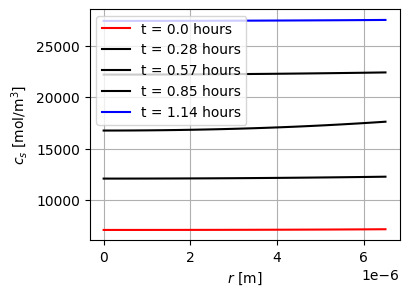

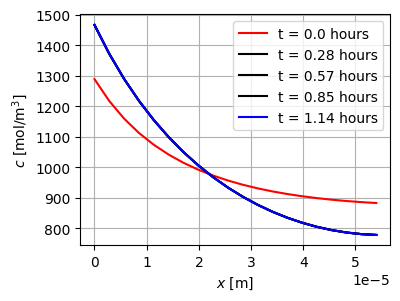

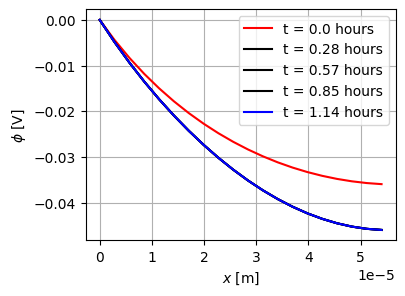

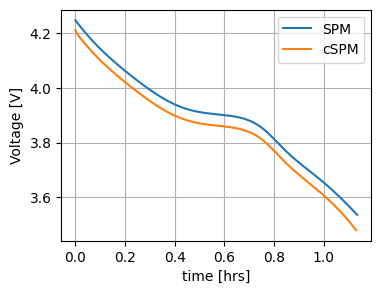

SPM Execution time: 0.580 seconds
cSPM Execution time: 2.038 seconds


In [5]:
solution = Solver.cSPM()  # Solve and store results
Plot.results(solution) # Plot and visualise results

### Model Validation Against Literature (cSPM by Richardson et al.)
This model is validated by comparing its results with those from the
cSPM presented in the paper by Richardson et al. and I extract the SPM, cSPM, and DFN data points from the paper.

This benchmarking helps ensure the developed model is robust and credible for 
further applications in battery diagnostics and control. 

In [10]:
# Import the SPM & cSPM & DFN Data
import Data

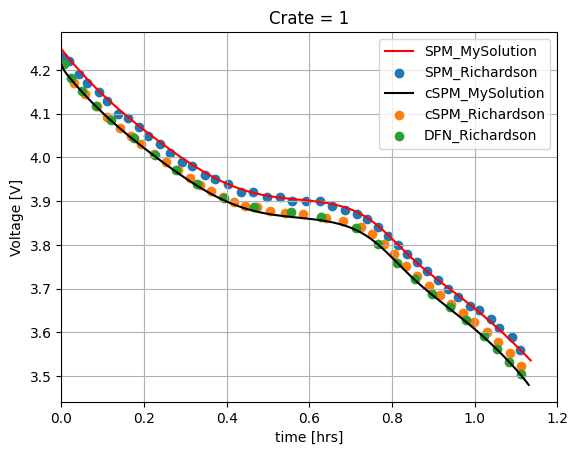

In [7]:
# Plotting
plt.figure()
plt.plot(solution["tnew"][:],solution["V_spm"][:],label='SPM_MySolution',color = 'r' )
plt.scatter(Data.SPM_data["1C"]["t"],Data.SPM_data["1C"]["V"],label='SPM_Richardson')
plt.plot(solution["tnew"][:-1],solution["V_cspm"][:],label='cSPM_MySolution',color = 'black' )
plt.scatter(Data.cSPM_data["1C"]["t"],Data.cSPM_data["1C"]["V"],label='cSPM_Richardson')
plt.scatter(Data.DFN_data["1C"]["t"],Data.DFN_data["1C"]["V"],label='DFN_Richardson')
plt.grid()
plt.legend()
plt.title('Crate = 1')
plt.ylabel("Voltage [V]")
plt.xlabel("time [hrs]")
plt.xlim(0,1.2)
plt.show()

# # Calculate RMSE
# # Interpolate Richardson data to match the time points of your SPM solution
# interp_V = interp1d(Data.SPM_data["1C"]["t"], Data.SPM_data["1C"]["V"], kind='linear', bounds_error=False, fill_value="extrapolate")
# # Interpolate reference voltage at model time points
# V_data = interp_V(solution["tnew"])
# rmse = np.sqrt(mean_squared_error(solution["V_spm"], V_data))
# print(f"RMSE between SPM and cSPM voltage: {rmse * 1000:.2f} mV")

## Diffusion and Equilibrium potential Functions

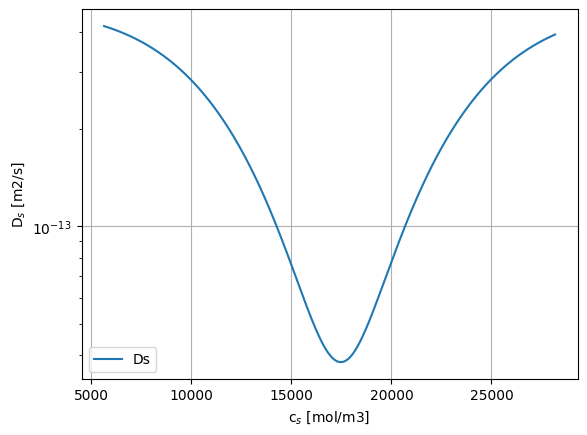

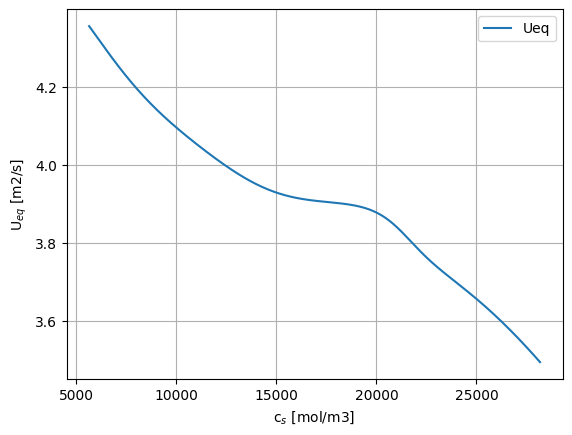

In [8]:
cs = np.linspace(2e-1,1,1000)
Ds = Functions.Ds_cs(cs)*Param.params["Ds"]
# Ds Function
plt.figure()
plt.semilogy(cs*Param.params["csmax"],Ds, label = "Ds")
plt.xlabel("c$_s$ [mol/m3]")
plt.ylabel("D$_s$ [m2/s]")
plt.legend()
plt.grid()
plt.show()

# Ueq Function
Ueq = Functions.Ueq_cathode(cs)*Param.params["U_hat"]
plt.figure()
plt.plot(cs*Param.params["csmax"],Ueq, label = "Ueq")
plt.xlabel("c$_s$ [mol/m3]")
plt.ylabel("U$_{eq}$ [m2/s]")
plt.legend()
plt.grid()
plt.show()

## Grid search

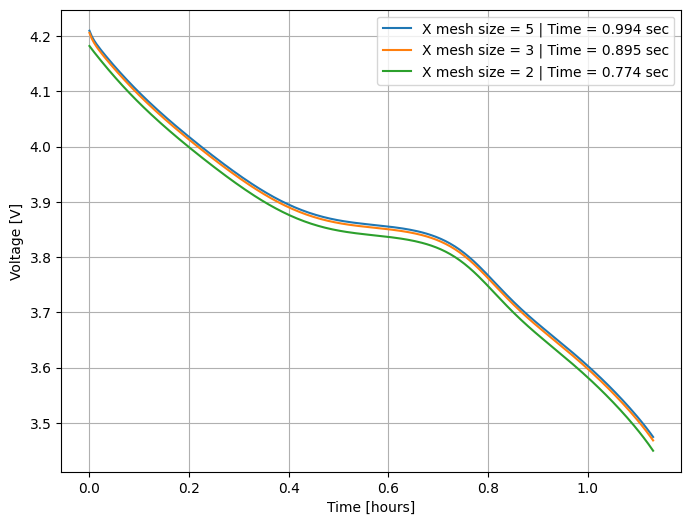

In [9]:
# Import the Grid search
import GridSearch
GridSearch.dx_Search([5,3,2])
# GridSearch.dr_Search([10,2])
# GridSearch.dt_Search([1e-2,1e-3])